# **Task 2: CRS Decisions**

----

In [1]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import os

In [2]:
clip_dir = "F:\\Data Visualization\\Case Study\\DATASETS\\Clip"

# Read shapefiles
adm4_ncr = gpd.read_file(os.path.join(clip_dir, "adm4_ncr.shp"))
flood_ncr = gpd.read_file(os.path.join(clip_dir, "flood_ncr.shp"))
health_ncr = gpd.read_file(os.path.join(clip_dir, "health_ncr.shp"))

road_layers_ncr = {}
for file in os.listdir(clip_dir):
    if file.startswith("road_") and file.endswith(".shp"):
        key = file.replace(".shp","")
        road_layers_ncr[key] = gpd.read_file(os.path.join(clip_dir, file))

In [3]:
proj_crs = "EPSG:32651"  # WGS 84 / UTM Zone 51N

adm4_ncr = adm4_ncr.to_crs(proj_crs)
flood_ncr = flood_ncr.to_crs(proj_crs)
health_ncr = health_ncr.to_crs(proj_crs)

for key, gdf in road_layers_ncr.items():
    road_layers_ncr[key] = gdf.to_crs(proj_crs)

In [4]:
# Print all CRS
print(f"ADM4 CRS: {adm4_ncr.crs}")
print(f"Flood CRS: {flood_ncr.crs}")
print(f"Health CRS: {health_ncr.crs}")
for key, gdf in road_layers_ncr.items():
    print(f"Road/Building Layer: {key} CRS: {gdf.crs}")
    

ADM4 CRS: EPSG:32651
Flood CRS: EPSG:32651
Health CRS: EPSG:32651
Road/Building Layer: road_buildings_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_buildings_Polygon_ncr CRS: EPSG:32651
Road/Building Layer: road_natural_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_places_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_pofw_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_pois_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_railways_LineString_ncr CRS: EPSG:32651
Road/Building Layer: road_traffic_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_transport_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_water_MultiPolygon_ncr CRS: EPSG:32651
Road/Building Layer: road_water_Polygon_ncr CRS: EPSG:32651


**Task 2 Deliverable:**

All clipped vector layers were reprojected to WGS 84 / UTM Zone 51N (EPSG:32651) to allow accurate distance and area calculations. This ensures flood buffers and barangay areas are correctly measured in meters. Geographic CRS (lat/lon) would distort these metrics, so a projected CRS was required.

# **Task 3: Geometry Hygiene**

----

In [5]:
# Check if buffering is needed

print(adm4_ncr.is_valid.all())
print(flood_ncr.is_valid.all())


True
True


In [6]:
# Simplify flood polygons to reduce vertices 
flood_simple = flood_ncr.copy()
flood_simple["geometry"] = flood_simple.geometry.simplify(tolerance=5)  # 5 meters tolerance

In [7]:
flood_buffer = flood_simple.copy()
flood_buffer["geometry"] = flood_buffer.geometry.buffer(100)

In [10]:
flood_buffer_dissolved = flood_buffer.dissolve()
admin_dissolved = adm4_ncr.dissolve(by="ADM3_EN")


C:\Users\cauba\AppData\Local\Temp\ipykernel_21256\1007052766.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\cauba\AppData\Local\Temp\ipykernel_21256\1007052766.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


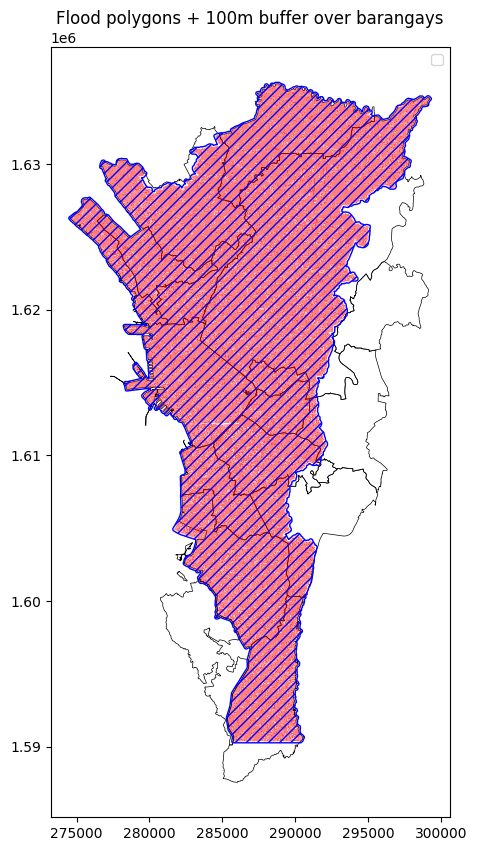

In [12]:
# --- 6. Plot ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
admin_dissolved.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, label="Municipalities")
flood_ncr.plot(ax=ax, color="red", alpha=0.5, label="Flood polygons")
flood_buffer_dissolved.plot(ax=ax, hatch="///", facecolor="none", edgecolor="blue", label="100m buffer")
plt.legend()
plt.title("Flood polygons + 100m buffer over barangays")
plt.show()

# save plot
fig.savefig("flood_buffer_plot.png", dpi=300)

### Task 4

In [43]:
# Ensure CRS match
adm4_ncr = adm4_ncr.to_crs(flood_buffer_dissolved.crs)

print(adm4_ncr.crs)
print(flood_buffer_dissolved.crs)

# --- Clip population raster to flood buffer extent ---
pop_raster_path = "C:/Users/cauba/OneDrive/Desktop/Case Study/DATASETS/Population/phl_ppp_2020.tif"

src = rasterio.open(pop_raster_path)
print(src.crs)

flood_buffer_wgs = flood_buffer_dissolved.to_crs(src.crs)
flood_geom = [flood_buffer_wgs.unary_union.__geo_interface__]
out_image, out_transform = mask(src, flood_geom, crop=True)

EPSG:32651
EPSG:32651
EPSG:4326


C:\Users\cauba\AppData\Local\Temp\ipykernel_21256\3136310114.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  flood_geom = [flood_buffer_wgs.unary_union.__geo_interface__]


In [ ]:
# 1. Compute population per barangay (zonal sum)
zs = zonal_stats(
    adm4_ncr,              # barangay GeoDataFrame
    out_image[0],          # the clipped raster array
    affine=out_transform,  # transform from the mask output
    stats="sum",
    nodata=src.nodata,
    geojson_out=False
)

# 2. Add population values to adm4_ncr
adm4_ncr["Population"] = [x["sum"] if x["sum"] is not None else 0 for x in zs]

# 3. Compute people-in-hazard
adm4_ncr["People_in_Hazard"] = (adm4_ncr["pct_area_in_buffer"] / 100) * adm4_ncr["Population"]

# 4. Prepare final table: top 10 barangays by people-in-hazard
top10 = adm4_ncr[["ADM4_EN", "ADM3_EN", "Population", "pct_area_in_buffer", "People_in_Hazard"]] \
    .sort_values("People_in_Hazard", ascending=False) \
    .head(10)

# 5. Rename columns for clarity
top10 = top10.rename(columns={
    "ADM4_EN": "Barangay",
    "ADM3_EN": "Municipality",
    "pct_area_in_buffer": "%Area_in_Buffer"
})

# 6. Display the table
print(top10)

MemoryError: Unable to allocate 24.8 TiB for an array with shape (2569605, 2650706) and data type float32